In [1]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_grid(imgs, titles, rows, cols, figsize):
    fig, axs = plt.subplots(rows, cols, figsize=figsize) # Cria um grid para as imgs
    for a, i, t in zip(axs.flatten(), imgs, titles):
        # Adiciona uma imagem (i) na posição correta (a):
        a.imshow(i, cmap='gray', aspect='equal', interpolation=None, vmin=0, vmax=255)
        a.set_title(t)
    # Desativa o eixo das imagens (separado pois o número de imgs pode não preencher o grid):
    for a in axs.flatten(): a.set_axis_off()

    plt.tight_layout()
    plt.show()
    return fig, axs

In [3]:
baboon = io.imread('./baboon.png').astype(np.uint8)
watch = io.imread('./watch.png').astype(np.uint8)

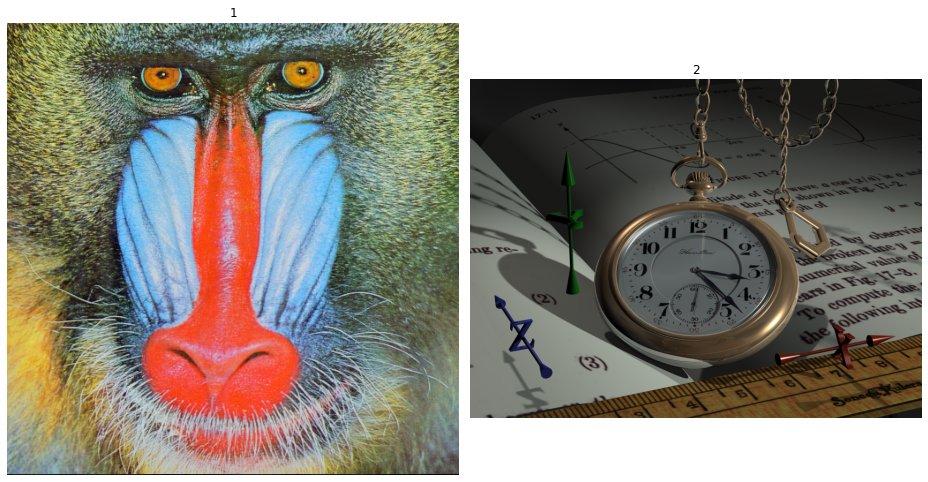

In [4]:
f1, axs1 = plot_grid([baboon, watch], range(1, 3), 1, 2, (13, 13))

In [5]:
f = open("music.txt", "rb")
file = list(f.read())
f.close()
size = len(file)

In [6]:
def encode(img, content, size, plane):
    # Checks if the file fits in the image:
    bit_file_size = 8 * (size + 4)  # 4 bytes for the size header
    if img.size < bit_file_size:
        raise Exception("File is too big!")

    # Adds the size header:
    size_bytes = list(size.to_bytes(4, 'big'))
    content = np.array(size_bytes + content, dtype=np.uint8)

    bit_file = np.unpackbits(content)  # unpacks each byte to a binary form

    # Creates the mask/values by shifting to the right plane:
    bit_values = bit_file << plane
    mask = np.full(bit_file_size, 1 << plane)

    # Pads the mask/values to be able to do a simple apply later:
    left_over = img.size - bit_file_size  # padding length to reach the original
    bit_values = np.pad(bit_values, (0, left_over), constant_values=0)
    mask = np.pad(mask, (0, left_over), constant_values=0)

    # Reshapes to match the original image:
    bit_values = bit_values.reshape(img.shape)
    mask = mask.reshape(img.shape)

    # Applies the mask:
    result = img & (255 - mask)  # erases the bits of the plane inside the mask
    result |= bit_values  # writes the new values
    return result


result = encode(baboon, file, size, 0).astype(np.uint8)
io.imsave('baboon-music.png', result, check_contrast=False)

In [7]:
def decode(img, plane):
    start = 7 - plane  # the first file bit in the flat unpacked array
    bit_file = np.unpackbits(img)[start::8]  # gets only the right plane
    file = np.packbits(bit_file)  # converts the bit array to a byte array
    # The size is the first four bytes:
    size = int.from_bytes(file[:4], byteorder='big', signed=False)
    return file[4:4 + size]  # crops the file out


decode_file = decode(result, 0)
f = open("music-decode.txt", "wb")
arr = bytearray(decode_file)
f.write(arr)
f.close()

In [8]:
def filter(img, bit, f=255):
    return f * ((img & (1 << bit)) >> bit)

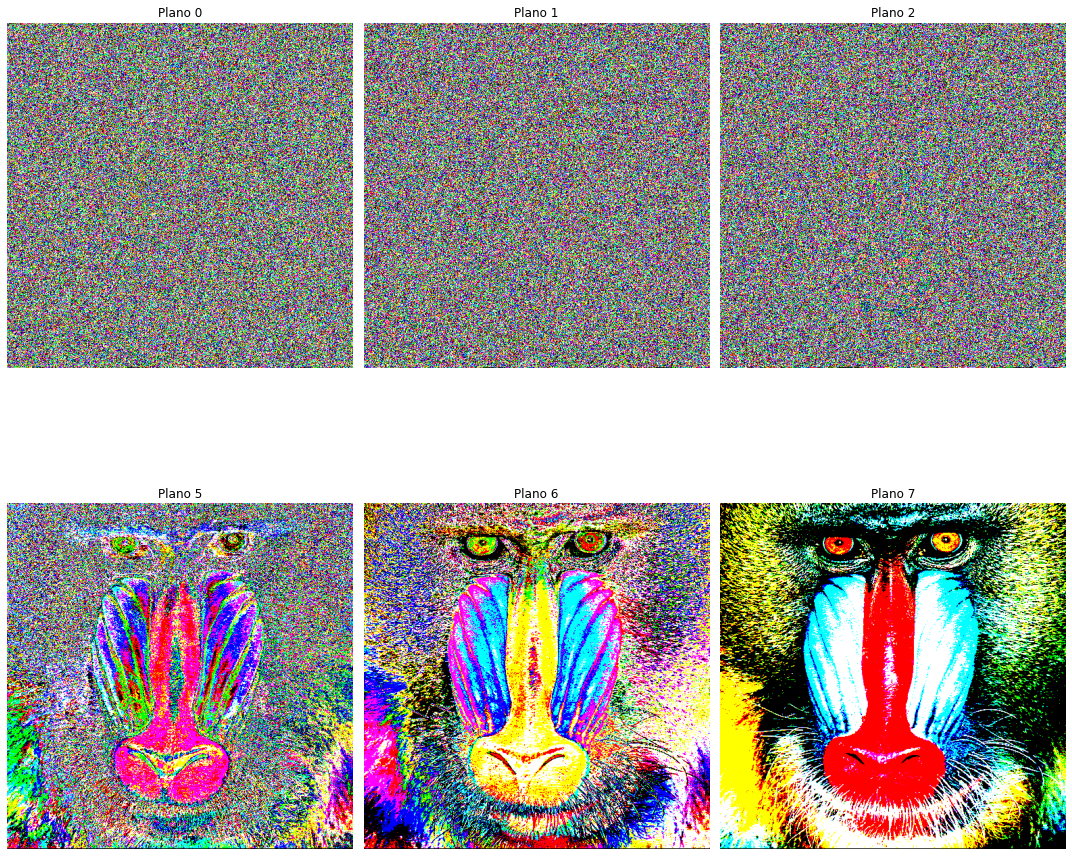

In [9]:
planes = [0, 1, 2, 5, 6, 7]
labels = ['Plano 0', 'Plano 1', 'Plano 2', 'Plano 5', 'Plano 6', 'Plano 7']

filtered = [filter(baboon, p) for p in planes]
f2, axs2 = plot_grid(filtered, labels, 2, 3, (15, 15))

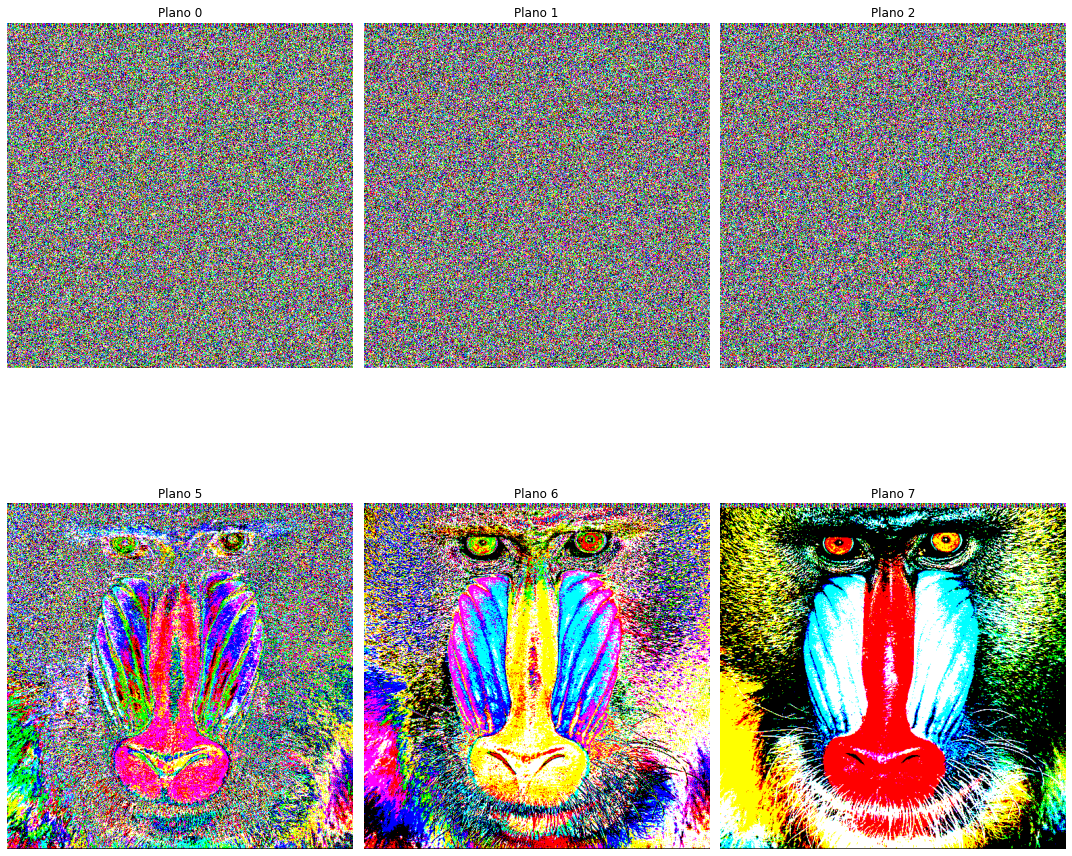

In [10]:
results = [encode(baboon, file, size, i).astype(np.uint8) for i in planes]
filtered = [filter(r, p) for p, r in zip(planes, results)]
f2, axs2 = plot_grid(filtered, labels, 2, 3, (15, 15))